In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc
from fastai.tabular import *
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold, StratifiedKFold
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import datetime
from tqdm.notebook import tqdm as tqdm_notebook

In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [3]:
from functools import partial
import re
import calendar

def add_cyclic_datepart(df, field_name:str, prefix:str=None, drop:bool=True, time:bool=False, add_linear:bool=False):
    "Helper function that adds trigonometric date/time features to a date in the column `field_name` of `df`."
    make_date(df, field_name)
    field = df[field_name]
    prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
    series = field.apply(partial(cyclic_dt_features, time=time, add_linear=add_linear))
    columns = [prefix + c for c in cyclic_dt_feat_names(time, add_linear)]
    df_feats = pd.DataFrame([item for item in series], columns=columns, index=series.index)
    for column in columns: df[column] = df_feats[column]
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df
def make_date(df, date_field:str):
    "Make sure `df[date_field]` is of the right date type."
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)
def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a
def cyclic_dt_features(d, time:bool=True, add_linear:bool=False):
    "Calculate the cos and sin of date/time cycles."
    tt,fs = d.timetuple(), [np.cos, np.sin]
    day_year,days_month = tt.tm_yday, calendar.monthrange(d.year, d.month)[1]
    days_year = 366 if calendar.isleap(d.year) else 365
    rs = d.weekday()/7, (d.day-1)/days_month, (d.month-1)/12, (day_year-1)/days_year
    feats = [f(r * 2 * np.pi) for r in rs for f in fs]
    """if time and isinstance(d, datetime) and type(d) != date:
        rs = tt.tm_hour/24, tt.tm_hour%12/12, tt.tm_min/60, tt.tm_sec/60
        feats += [f(r * 2 * np.pi) for r in rs for f in fs]"""
    """if add_linear:
        if type(d) == date: feats.append(d.year + rs[-1])
        else:
            secs_in_year = (datetime(d.year+1, 1, 1) - datetime(d.year, 1, 1)).total_seconds()
            feats.append(d.year + ((d - datetime(d.year, 1, 1)).total_seconds() / secs_in_year))"""
    return feats
def cyclic_dt_feat_names(time:bool=True, add_linear:bool=False):
    "Return feature names of date/time cycles as produced by `cyclic_dt_features`."
    fs = ['cos','sin']
    attr = [f'{r}_{f}' for r in 'weekday day_month month_year day_year'.split() for f in fs]
    if time: attr += [f'{r}_{f}' for r in 'hour clock min sec'.split() for f in fs]
    if add_linear: attr.append('year_lin')
    return attr

In [4]:
# this function will help to reduce momory 
# data will be smaller with the same value

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
train = pd.read_csv('../input/urban-air-pollution/Train.csv')
test = pd.read_csv('../input/urban-air-pollution/Test.csv')
sample_sub = pd.read_csv('../input/urban-air-pollution/SampleSubmission.csv')

In [6]:
train['Date'] = pd.to_datetime(train['Date'], format='%Y-%m-%d')
test['Date'] = pd.to_datetime(test['Date'], format='%Y-%m-%d')
ID_COL, TARGET_COL = 'Place_ID X Date', 'target'
df = pd.concat([train, test]).reset_index(drop=True)
features = [c for c in df.columns if c not in ['Date', 'target_count', 'target_min', 'Place_ID X Date', 'target_variance', 'Place_ID', 'target_max', 'target']]
simple_feats = [c for c in features if ('angle' not in c) & ('height' not in c) & ('altittude' not in c)]
len(simple_feats)

38

In [7]:
nan_cols = [c for c in df.columns if c not in ["target_max","target","target_min","target_variance", "target_count"]]
nan_cols = df[nan_cols].columns[df[nan_cols].isnull().any()].tolist()

for col in nan_cols:
    
    while df[col].isnull().sum()>0:
     
        df[col].fillna(df[["Place_ID", col]].groupby(["Place_ID"]).shift(periods=0).fillna(method='ffill', limit=1).fillna(method='bfill', limit=1)[col], inplace=True) 

df.isnull().sum()[df.isnull().sum()>0]

target             16136
target_min         16136
target_max         16136
target_variance    16136
target_count       16136
dtype: int64

In [8]:
df['placeID_freq'] = df['Place_ID'].map(df['Place_ID'].value_counts())
"""for i in range(1, 20):
    df[f'prev_target_{i}'] = df.sort_values(by='Date')[TARGET_COL].shift(i).fillna(method='ffill').fillna(method='bfill').sort_index()
    df[f'next_target_{i}'] = df.sort_values(by='Date')[TARGET_COL].shift(-i).fillna(method='bfill').fillna(method='ffill').sort_index()

for i in tqdm_notebook(range(1, 15)):
    df[f'magic_{i}'] = df.sort_values(by='Date')[TARGET_COL].shift(i).expanding().mean().fillna(method='ffill').fillna(method='bfill').sort_index()
    df[f'magic2_{i}'] = df.sort_values(by='Date')[TARGET_COL].shift(-i).expanding().mean().fillna(method='bfill').fillna(method='ffill').sort_index()
    """
for i in tqdm_notebook(range(1, 45)):
    c = 'Date' + str(i+1)
    df[c] = df['Date']  + datetime.timedelta(days=i)
    _ = add_cyclic_datepart(df, c, prefix = c)
    
for i in tqdm_notebook(range(1, 11)):
    tmp = df.sort_values(by='Date').groupby('Place_ID')[simple_feats].shift(i).fillna(method='ffill').fillna(method='bfill').sort_index()
    tmp_diff_prev = df[simple_feats] - tmp
    tmp.columns = [c + f'_prev_{i}' for c in tmp.columns]
    tmp_diff_prev.columns = [c + f'_prev_diff_{i}' for c in tmp_diff_prev.columns]
    df = pd.concat([df, tmp, tmp_diff_prev], axis=1)
    
    tmp = df.sort_values(by='Date').groupby('Place_ID')[simple_feats].shift(-i).fillna(method='bfill').fillna(method='ffill').sort_index()
    tmp_diff_next = df[simple_feats] - tmp
    tmp.columns = [c + f'_next_{i}' for c in tmp.columns]
    tmp_diff_next.columns = [c + f'_next_diff_{i}' for c in tmp_diff_next.columns]
    df = pd.concat([df, tmp, tmp_diff_next], axis=1)
    
for attr in ['day', 'month', 'week', 'dayofweek', 'weekofyear', 'days_in_month', 'is_month_start', 'is_month_end', 'dayofyear']:
    df[attr] = getattr(df['Date'].dt, attr)
df['is_weekend'] = (df['dayofweek'] >= 5)*1
df['fortnight'] = df['day']%15
df['which_fortnight'] = df['day']//15
add_cyclic_datepart(df, "Date", prefix = "Current_Date_")

"for i in range(1, 20):\n    df[f'prev_target_{i}'] = df.sort_values(by='Date')[TARGET_COL].shift(i).fillna(method='ffill').fillna(method='bfill').sort_index()\n    df[f'next_target_{i}'] = df.sort_values(by='Date')[TARGET_COL].shift(-i).fillna(method='bfill').fillna(method='ffill').sort_index()\n\nfor i in tqdm_notebook(range(1, 15)):\n    df[f'magic_{i}'] = df.sort_values(by='Date')[TARGET_COL].shift(i).expanding().mean().fillna(method='ffill').fillna(method='bfill').sort_index()\n    df[f'magic2_{i}'] = df.sort_values(by='Date')[TARGET_COL].shift(-i).expanding().mean().fillna(method='bfill').fillna(method='ffill').sort_index()\n    "

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,Place_ID X Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,...,fortnight,which_fortnight,Current_Date_weekday_cos,Current_Date_weekday_sin,Current_Date_day_month_cos,Current_Date_day_month_sin,Current_Date_month_year_cos,Current_Date_month_year_sin,Current_Date_day_year_cos,Current_Date_day_year_sin
0,010Q650 X 2020-01-02,010Q650,38.0,23.0,53.0,769.50,92.0,11.000000,60.200001,0.00804,...,2,0,-0.900969,0.433884,0.979530,0.201299,1.000000e+00,0.000000,0.999853,0.017166
1,010Q650 X 2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91.0,14.600000,48.799999,0.00839,...,3,0,-0.900969,-0.433884,0.918958,0.394356,1.000000e+00,0.000000,0.999411,0.034328
2,010Q650 X 2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96.0,16.400000,33.400002,0.00750,...,4,0,-0.222521,-0.974928,0.820763,0.571268,1.000000e+00,0.000000,0.998674,0.051479
3,010Q650 X 2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96.0,6.911948,21.300001,0.00391,...,5,0,0.623490,-0.781831,0.688967,0.724793,1.000000e+00,0.000000,0.997643,0.068615
4,010Q650 X 2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95.0,13.900001,44.700001,0.00535,...,6,0,1.000000,0.000000,0.528964,0.848644,1.000000e+00,0.000000,0.996318,0.085731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46688,ZZDJZMS X 2020-03-31,ZZDJZMS,NaN,NaN,NaN,NaN,NaN,9.400001,86.200005,0.00413,...,1,2,0.623490,0.781831,0.979530,-0.201299,5.000000e-01,0.866025,0.025748,0.999668
46689,ZZDJZMS X 2020-04-01,ZZDJZMS,NaN,NaN,NaN,NaN,NaN,17.000000,90.300003,0.00548,...,1,0,-0.222521,0.974928,1.000000,0.000000,6.123234e-17,1.000000,0.008583,0.999963
46690,ZZDJZMS X 2020-04-02,ZZDJZMS,NaN,NaN,NaN,NaN,NaN,19.170641,86.200005,0.00656,...,2,0,-0.900969,0.433884,0.978148,0.207912,6.123234e-17,1.000000,-0.008583,0.999963
46691,ZZDJZMS X 2020-04-03,ZZDJZMS,NaN,NaN,NaN,NaN,NaN,8.400001,66.400002,0.00457,...,3,0,-0.900969,-0.433884,0.913545,0.406737,6.123234e-17,1.000000,-0.025748,0.999668


In [9]:
df.isnull().sum()[df.isnull().sum()>0]

target             16136
target_min         16136
target_max         16136
target_variance    16136
target_count       16136
dtype: int64

In [10]:
features = [c for c in df.columns if c not in ['Date', 'target_count', 'target_min', 'Place_ID X Date', 'target_variance', 'Place_ID',
                                               'target_max', 'target',  'month_year_cos','month_year_sin','day_year_cos','day_year_sin']]
train = df[:train.shape[0]].reset_index(drop=True)
test = df[train.shape[0]:].reset_index(drop=True)
target = train[TARGET_COL]
len(features)

1967

In [11]:
train = reduce_mem_usage(train)
print('\n ************************* \n')
test = reduce_mem_usage(test)

Memory usage of dataframe is 459.79 MB
Memory usage after optimization is: 126.82 MB
Decreased by 72.4%

 ************************* 

Memory usage of dataframe is 242.80 MB
Memory usage after optimization is: 67.37 MB
Decreased by 72.3%


In [12]:
del df
import gc
gc.collect()

21

In [13]:
param = {'num_leaves': 100,
         'min_data_in_leaf': 40, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.05,
         "boosting": "gbdt",
         "feature_fraction": 0.35,
         "metric": 'auc',
         "lambda_l1": 1,
         "lambda_l2": 1,
         "random_state": 6,
         "verbosity": -1,
          'metric' : 'rmse',
          'num_iterations': 2600}

In [14]:
target_cols = ['target']
oofs_df = pd.DataFrame()
preds_df = pd.DataFrame()
for t_col in target_cols:
    oofs_df[t_col] = np.zeros(len(train))
    preds_df[t_col] = np.zeros(len(test))

In [15]:
max_iter = 10
folds = StratifiedKFold(n_splits=max_iter, random_state=None)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, pd.qcut(target, 10, labels=False, duplicates='drop'))):
    print("\nfold n°{}".format(fold_))
    X_trn, X_val, X_test = train.iloc[trn_idx][features], train.iloc[val_idx][features], test[features]
    for t_col in target_cols:
        target = train[t_col]
        print(f"\n\n**** {t_col} ****\n")
        y_trn, y_val = target.iloc[trn_idx], target.iloc[val_idx]
        trn_data = lgb.Dataset(X_trn, y_trn)
        val_data = lgb.Dataset(X_val, y_val)
        
        clf = lgb.train(param, trn_data, valid_sets = [trn_data, val_data], verbose_eval=50, early_stopping_rounds = 200)

        oofs_df[t_col][val_idx] = clf.predict(X_val, num_iteration=clf.best_iteration)
        current_test_pred = clf.predict(X_test, num_iteration=clf.best_iteration)
        current_test_pred[current_test_pred < 0] = 0
        preds_df[t_col] += current_test_pred / folds.n_splits
  


fold n°0


**** target ****



/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 200 rounds
[50]	training's rmse: 23.6682	valid_1's rmse: 27.6231
[100]	training's rmse: 18.2292	valid_1's rmse: 25.73
[150]	training's rmse: 14.9442	valid_1's rmse: 25.0861
[200]	training's rmse: 12.6388	valid_1's rmse: 24.7762
[250]	training's rmse: 10.8419	valid_1's rmse: 24.5847
[300]	training's rmse: 9.42407	valid_1's rmse: 24.4401
[350]	training's rmse: 8.27495	valid_1's rmse: 24.3631
[400]	training's rmse: 7.31471	valid_1's rmse: 24.2946
[450]	training's rmse: 6.49345	valid_1's rmse: 24.2332
[500]	training's rmse: 5.79321	valid_1's rmse: 24.2039
[550]	training's rmse: 5.18861	valid_1's rmse: 24.1952
[600]	training's rmse: 4.65043	valid_1's rmse: 24.1719
[650]	training's rmse: 4.17324	valid_1's rmse: 24.1539
[700]	training's rmse: 3.75862	valid_1's rmse: 24.1325
[750]	training's rmse: 3.38919	valid_1's rmse: 24.1287
[800]	training's rmse: 3.06483	valid_1's rmse: 24.1216
[850]	training's rmse: 2.78127	valid_1's rmse: 24.1153
[900]	

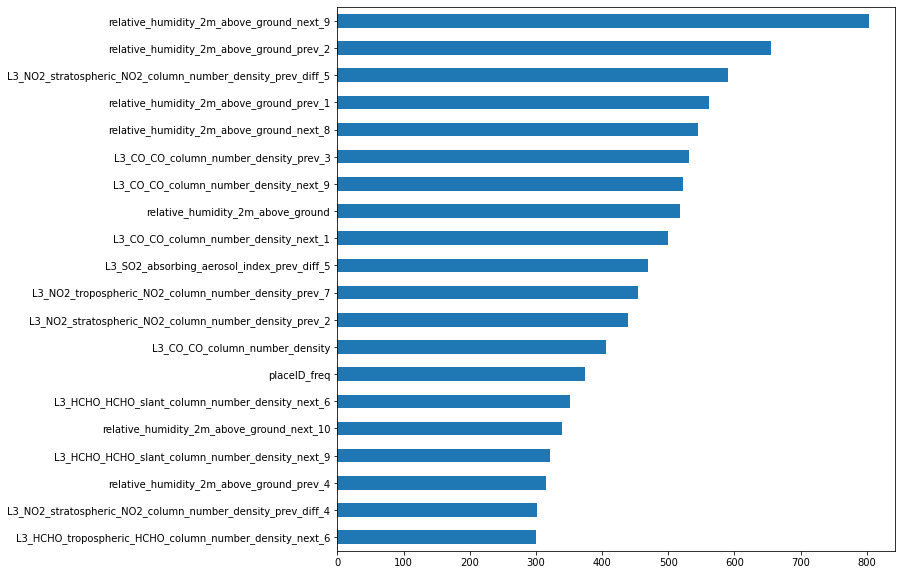

In [16]:
import matplotlib.pyplot as plt


_ = plt.figure(figsize=(10, 10))
fi = pd.Series(index=features, data=clf.feature_importance())
_ = fi.sort_values()[-20:].plot(kind='barh')

In [17]:
rmse(target.values, oofs_df['target'].values)

27.452747156953095

In [18]:
predictions_test = preds_df['target'] 
predictions_test[predictions_test < 0] = 0

In [19]:
SUB_FILE_NAME = 'preds_lgbm_v3.csv'
sub_df = pd.DataFrame()
sub_df[ID_COL] = test[ID_COL]
sub_df[TARGET_COL] = predictions_test
sub_df.to_csv(SUB_FILE_NAME, index=False)
sub_df.head(10)

,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,31.193464
1,0OS9LVX X 2020-01-03,30.972599
2,0OS9LVX X 2020-01-04,24.961742
3,0OS9LVX X 2020-01-05,29.665415
4,0OS9LVX X 2020-01-06,39.012339
5,0OS9LVX X 2020-01-07,45.774243
6,0OS9LVX X 2020-01-08,26.127774
7,0OS9LVX X 2020-01-09,25.643629
8,0OS9LVX X 2020-01-10,33.025017
9,0OS9LVX X 2020-01-11,36.871589


In [20]:
sub_df[TARGET_COL].describe()

count    16136.000000
mean        58.114964
std         35.257667
min          1.114905
25%         31.939048
50%         48.487246
75%         75.303548
max        284.535280
Name: target, dtype: float64